# Example 4 Groups Comparison

This example performs an analysis tip data in the file `/data/tips.csv`. The data contains 244 tips and records the following features,

| Feature | Description | Unit|
|---------|-------------|------|
|`Total Bill` | Total cost of meal.| Dollars | 
| `Sex` | Male or Female.| (M, F) | 
| `Smoker` | Do the guests smoke.| (Yes, No) |
| `Day` | Day of week. | (Thu, Fri, Sat, Sun) |
| `Time` | Time of Day. | (Day, Night) |
| `Size` | Number of guests. | Count |

In this analysis the impact of the `Day` feature will be determined by comparing the tips for each day. Since there are four day variables the model distributions will be four dimensional.

In [1]:
%reload_ext autoreload
%autoreload 2

# import system modules and set local import path
import os
import sys
import numpy
import pandas
from matplotlib import pyplot
from scipy import stats
import pymc
import arviz

sys.path.insert(0, os.path.abspath('../..'))

from lib import config
from lib.plots import (curve, comparison, scatter, ridge_plot)

pyplot.style.use(config.glyfish_style)

In [2]:
tips = pandas.read_csv('../../data/tips.csv', delimiter='\t')
tips.head()

,TotBill,Tip,Sex,Smoker,Day,Time,Size
0,18.29,3.76,M,Yes,Sat,Night,4
1,16.99,1.01,F,No,Sun,Night,2
2,10.34,1.66,M,No,Sun,Night,3
3,21.01,3.50,M,No,Sun,Night,3
4,23.68,3.31,M,No,Sun,Night,2


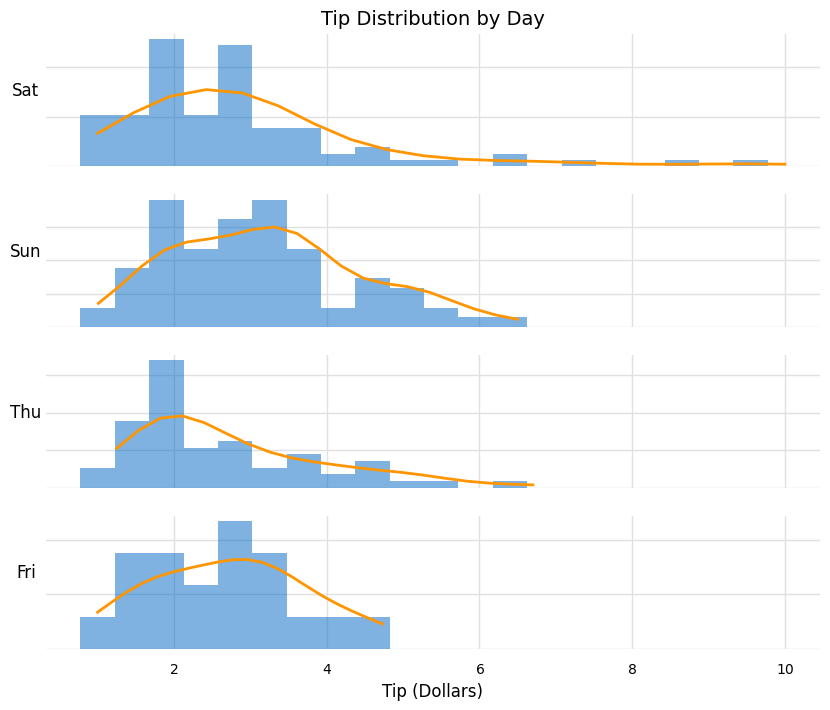

In [27]:
days = tips.Day.unique()
tips_by_day = [tips[tips.Day == day].Tip.values for day in days]

ridge_plot(days, tips_by_day, nbins=20, nkde=20, xlabel='Tip (Dollars)', title='Tip Distribution by Day')

In [63]:
def plot_gamma_pdf(idx):
    alpha_vals = [0.1, 0.5, 1.0, 2.0, 5.0, 7.0, 9.0, 11.0]
    beta_vals = [0.5, 1.0, 2.0]
    x_vals = numpy.linspace(0.01, 10, 100)
    title = f"Example of Gamma Distributions, $\\beta$ = {beta_vals[idx]}"
    pdfs = [numpy.array(stats.gamma.pdf(x_vals, a=alpha, scale=beta_vals[idx])) for alpha in alpha_vals]
    labels = [f'$\\alpha$ = {alpha}' for alpha in alpha_vals]
    comparison(pdfs, x_vals, title=title, labels=labels, xlabel='x', ylabel='PDF', ylim=(0, 1.0))

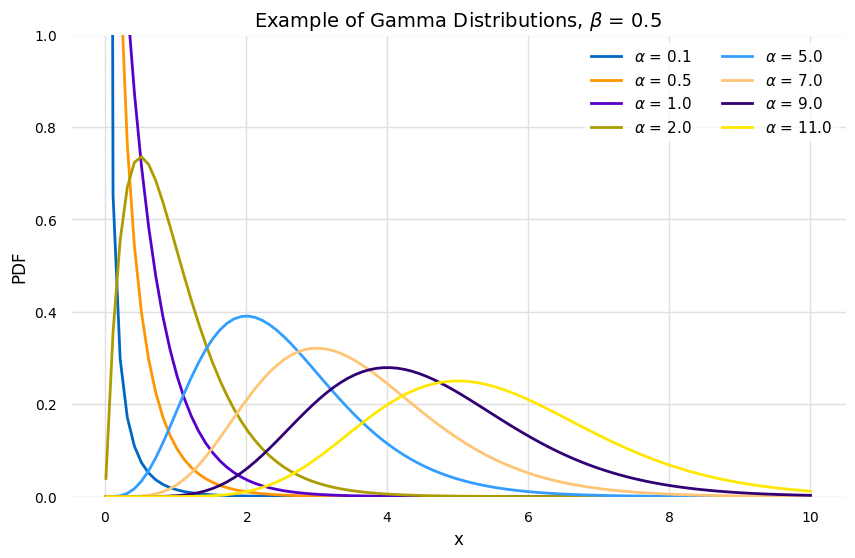

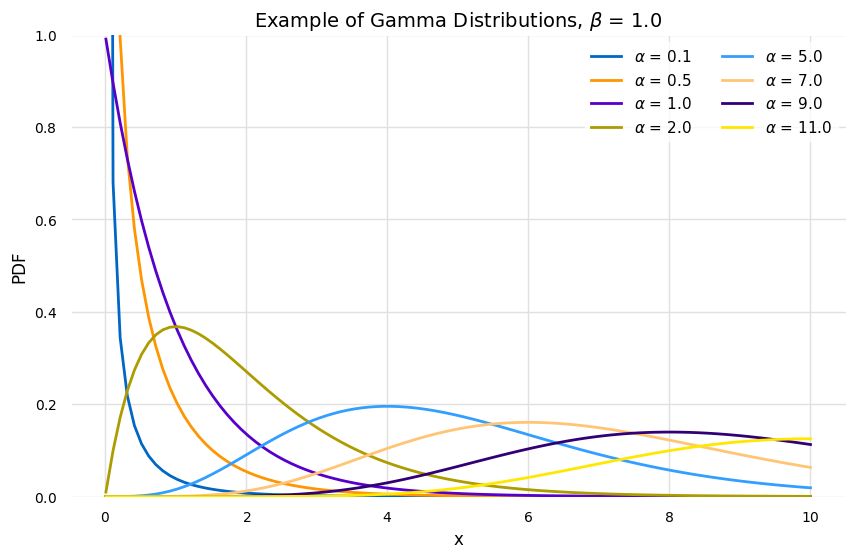

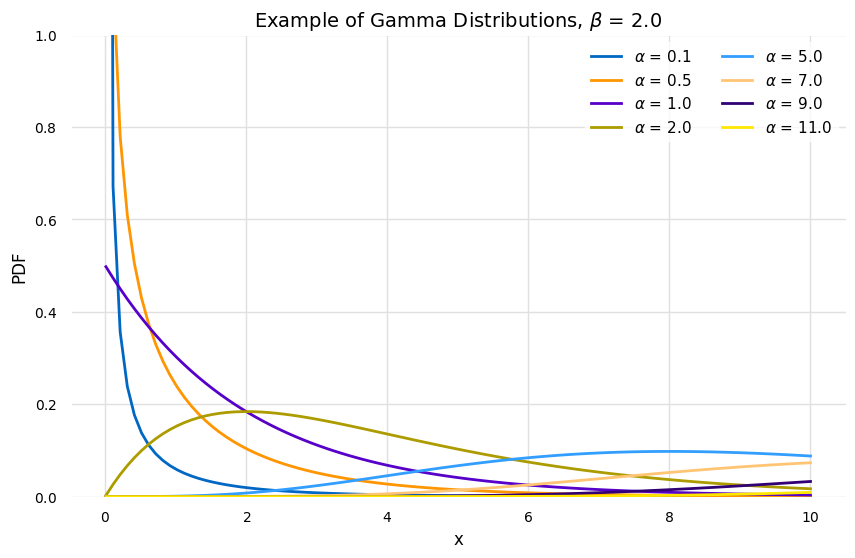

In [65]:
plot_gamma_pdf(0)
plot_gamma_pdf(1)
plot_gamma_pdf(2)

In [71]:
days = numpy.array(['Thu', 'Fri', 'Sat', 'Sun'])
tip_vals = tips.Tip.values
idx = pandas.Categorical(tips.Day, categories=days).codes
coords = {'Day': days, 'Obs': days[idx]}

In [75]:
mu_sigma = 10.0
sigma_sigma = 10.0
shape = 4

with pymc.Model(coords=coords) as model:
    μ = pymc.HalfNormal('μ', sigma=mu_sigma, shape=shape)
    σ = pymc.HalfNormal('σ', sigma=sigma_sigma, shape=shape)
    y = pymc.Gamma('Y', mu=μ[idx], sigma=σ[idx], observed=tip_vals, dims='Obs')
    
    idata = pymc.sample()
    idata.extend(pymc.sample_posterior_predictive(idata))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [Y]


Output()

KeyError: "No variable named 'Obs'. Variables on the dataset include ['Y_dim_0', 'Y']"

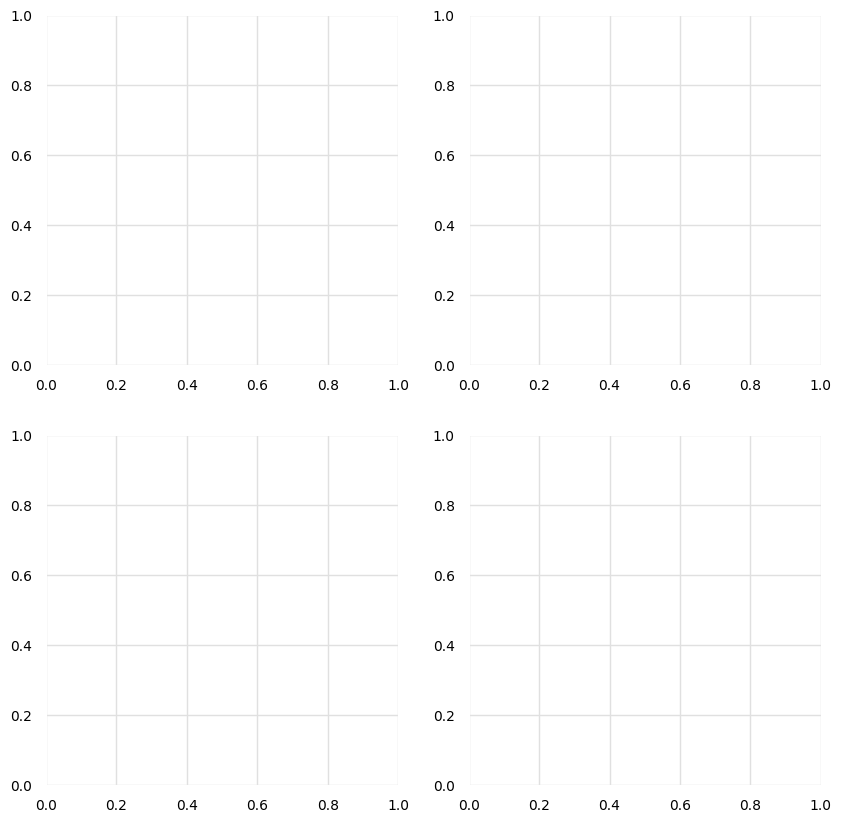

In [73]:
_, ax = pyplot.subplots(2, 2, figsize=(14, 10))
arviz.plot_ppc(idata, num_pp_samples=100, coords={'Obs':[days]}, flatten=[], ax=ax)